## Neuroinformatics Project 1: MRI upscaling


## Imports


In [1]:
import os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torch.optim as optim
from torch.optim import lr_scheduler


from tempfile import TemporaryDirectory

import torch.backends.cudnn as cudnn

import nibabel as nib
from nilearn import plotting



from extract_slices import (
    # load_nifti,
    slice_to_base64,
    base64_to_slice,
    volume_to_submission_rows,
    create_submission_df
)

from metric_pt2 import compute_ms_ssim
# import extract_slices


from tqdm import tqdm 

device = "cpu"
# if torch.backends.mps.is_available():
#     device = "mps"
if torch.cuda.is_available():
    device = "cuda"
    cudnn.benchmark = True
    
print("device:", device)




# Configuration
CONFIG = {
    "SEED": 42,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "BATCH_SIZE": 1,
    "LR": 2e-4,
    "WEIGHT_DECAY": 1e-5,
    "NUM_EPOCHS": 2,
    "PATIENCE": 10,
    "PATCH_SIZE": (96, 96, 96),
    "PATHS": {
        "TRAIN": "./train/",
        "TEST": "./test/",
        "CHECKPOINT": "./runs/checkpoint_final",
    },
}



# Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


set_seed(CONFIG["SEED"])
print(f"Running on: {CONFIG['DEVICE']}")

device: cpu
Running on: cpu


### normalize mri


In [2]:
def normalize_mri(tensor):
    # Min-Max Scaling to [0, 1]
    denom = tensor.max() - tensor.min()
    return (tensor - tensor.min()) / denom

In [3]:
def load_nifti(path, normalize=True):
    """
    Load a NIfTI file and return the data array.

    Args:
        path: Path to .nii.gz file

    Returns:
        3D numpy array (x, y, z)
    """
    img = nib.load(path).get_fdata()

    if normalize:
        img = normalize_mri(img)

    return img

In [4]:
def display_nifti(img):
    """
    Display a NIfTI file give fdata().

    Args:
        img: fdata associated with a nifti file
    """

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.imshow(img[img.shape[0] // 2, :, :].T, cmap="gray", origin="lower")
    plt.title("Middle Slice")
    plt.axis("off")

    plt.tight_layout()

    plt.show()

In [5]:
# PROJECT_DIR = "N:/OneDrive - Youngstown State University/3. NYU/25-26/Spring 2026/Neuroinformatics/Projects/Project 1"
PROJECT_DIR = "./"

TRAIN_DIR = os.path.join(PROJECT_DIR, "train/")
TEST_DIR = os.path.join(PROJECT_DIR, "test/")

HF_TRAIN = os.path.join(TRAIN_DIR, "high_field/")
LF_TRAIN = os.path.join(TRAIN_DIR, "low_field/")

LF_TEST = os.path.join(TEST_DIR, "low_field/")

TRAIN_GROUND_TRUTH_PATH = os.path.join(PROJECT_DIR, "train.csv")

# Synthetic dataset

# SYNTHETIC_HF = os.path.join(PROJECT_DIR, "simulated_data/HR/")
# SYNTHETIC_LF = os.path.join(PROJECT_DIR, "simulated_data/LR/")


print(HF_TRAIN)
# print(SYNTHETIC_HF)

./train/high_field/


In [6]:
ground_truth_df = pd.read_csv(TRAIN_GROUND_TRUTH_PATH)

ground_truth_df.head()

,row_id,ground_truth
0,sample_001_slice_000,UEsDBC0AAAAIAAAAIQCRRkEa//////////8JABQAc2xpY2...
1,sample_001_slice_001,UEsDBC0AAAAIAAAAIQCGlxaq//////////8JABQAc2xpY2...
2,sample_001_slice_002,UEsDBC0AAAAIAAAAIQBbPb4m//////////8JABQAc2xpY2...
3,sample_001_slice_003,UEsDBC0AAAAIAAAAIQCpeNev//////////8JABQAc2xpY2...
4,sample_001_slice_004,UEsDBC0AAAAIAAAAIQBOZi+L//////////8JABQAc2xpY2...


## Trial image loading


In [7]:
def load_nifti_pair(sample_id):

    LF_sample_path = os.path.join(LF_TRAIN, f"{sample_id}_lowfield.nii")
    HF_sample_path = os.path.join(HF_TRAIN, f"{sample_id}_highfield.nii")

    return {"lowfield": LF_sample_path, "highfield": HF_sample_path}

In [8]:
sample_id = "sample_001"

sample_path_pair = load_nifti_pair(sample_id)

# for sample_path in sample_path_pair.items():
#     volume = load_nifti(sample_path[1], normalize=True)

#     volume = normalize_mri(volume)

#     print(volume)

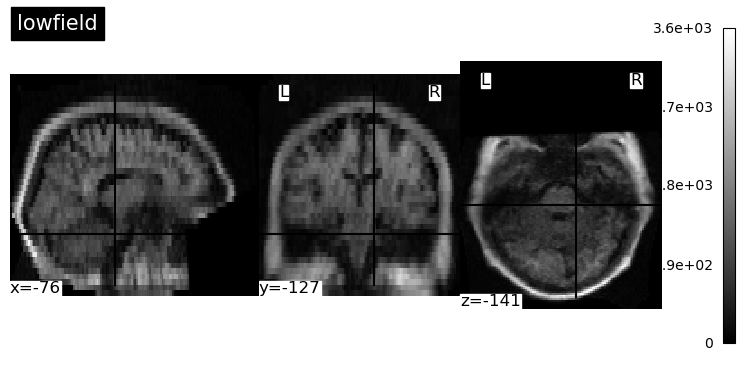

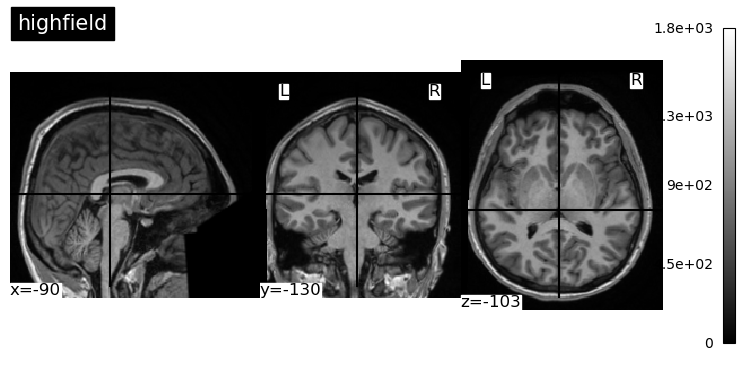

In [9]:
for sample_path in sample_path_pair.items():
    plotting.plot_img(sample_path[1], title=sample_path[0])

### Synthetic Data


In [10]:
# def load_synthetic_nifti_pair(sample_id):
#     LF_sample_path = os.path.join(
#         SYNTHETIC_LF,
#         f"08-Apr-2022_Ernst_labels_{sample_id}_3T_T1w_MPR1_img_act_1_contrast_1_Res_1_1_1_img.nii.gz",
#     )
#     HF_sample_path = os.path.join(
#         SYNTHETIC_HF,
#         f"08-Apr-2022_Ernst_labels_{sample_id}_3T_T1w_MPR1_img_act_1_contrast_1_Res_0.7_0.7_1_img.nii.gz",
#     )

#     return {"lowfield": LF_sample_path, "highfield": HF_sample_path}

In [11]:
# sample_id = 100206

# sample_synthetic_path_pair = load_synthetic_nifti_pair(sample_id)

# for sample_path in sample_synthetic_path_pair.items():
#     volume = load_nifti(sample_path[1], normalize=True)

#     volume = normalize_mri(volume)

#     print(volume)

In [12]:
# for sample_path in sample_synthetic_path_pair.items():
#     plotting.plot_img(sample_path[1], title=sample_path[0])

## Trilinear interpolation


In [13]:
def prepare_input(low_field_path, target_shape=(179, 221, 200)):
    # 1. Load the NIfTI file
    img_nifti = nib.load(low_field_path)
    # print(f"Low-field shape: {img_nifti.shape}")   # Should be (112, 138, 40)
    img_data = img_nifti.get_fdata()
    affine = img_nifti.affine

    # 2. Convert to PyTorch tensor [Batch, Channel, H, W, D]
    tensor = torch.from_numpy(img_data).float().unsqueeze(0).unsqueeze(0)

    # print(f"Tensor Shape: {tensor.shape}")

    # 3. Upsample to match High-Field dimensions
    # 'trilinear' is essential for 3D data to keep it smooth
    upsampled = F.interpolate(
        tensor, size=target_shape, mode="trilinear", align_corners=True
    )

    return upsampled.squeeze(0), affine  # Returns [1, 179, 221, 200] and the affine

In [14]:
def plot_image_trio(path_pair):
    # Test it on one file
    low_path = list(path_pair.items())[0][1]
    high_path = list(path_pair.items())[1][1]

    if os.path.exists(low_path) and os.path.exists(high_path):

        high_nifti = nib.load(high_path)
        target_shape = high_nifti.get_fdata().shape
        print(f"target_shape:{target_shape}")

        processed_tensor, original_affine = prepare_input(low_path, target_shape)

        data_array = processed_tensor.detach().cpu().numpy().squeeze()

        low_shape = nib.load(low_path).shape
        scale_factors = np.array(low_shape) / np.array(data_array.shape)

        new_affine = original_affine.copy()
        new_affine[:3, :3] = original_affine[:3, :3] * scale_factors

        viz_img = nib.Nifti1Image(data_array, new_affine)

        # 1. Plot the Upsampled Image first and capture the display object
        # (We plot this one first or capture it so we can use its coordinates for the others)
        upsampled_display = plotting.plot_img(
            viz_img,
            title="Upsampled Low-Field MRI (Trilinear)",
            display_mode="ortho",
            colorbar=True,
        )

        # 2. Extract the automatically selected cut coordinates (x, y, z)
        # These are the world coordinates chosen by nilearn for the upsampled image
        ref_coords = upsampled_display.cut_coords

        # 3. Plot the Target High-Field using the same coordinates
        # We pass 'ref_coords' to cut_coords to force the exact same view
        plotting.plot_img(
            high_nifti,
            title="Target High-Field",
            display_mode="ortho",
            cut_coords=ref_coords,
        )

        # Optional: You can also sync the original low-field to these coordinates
        # for a perfect 3-way comparison:
        plotting.plot_img(
            low_path,
            title="Original Low-Field",
            display_mode="ortho",
            cut_coords=ref_coords,
        )

        plotting.show()

### Project Data


target_shape:(179, 221, 200)


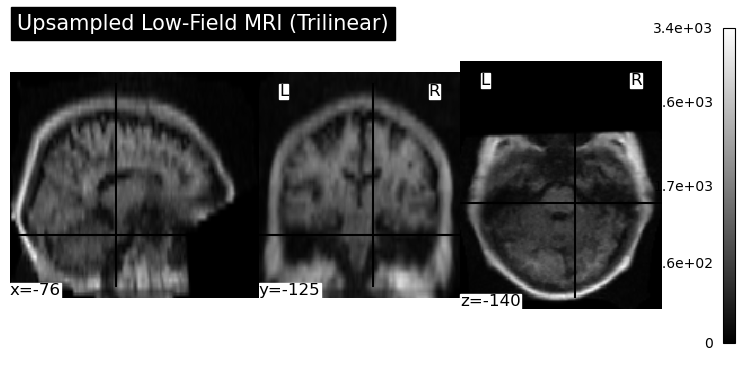

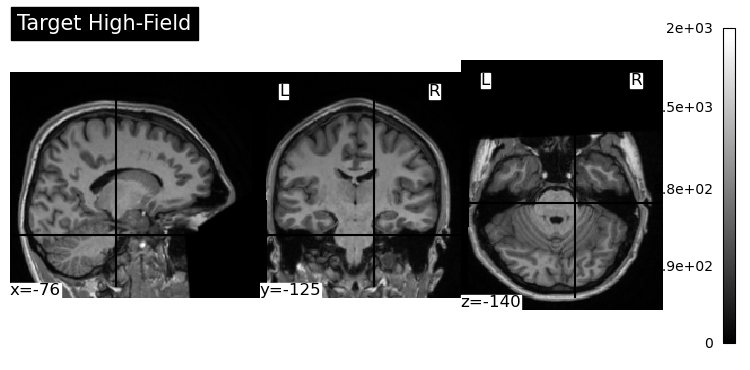

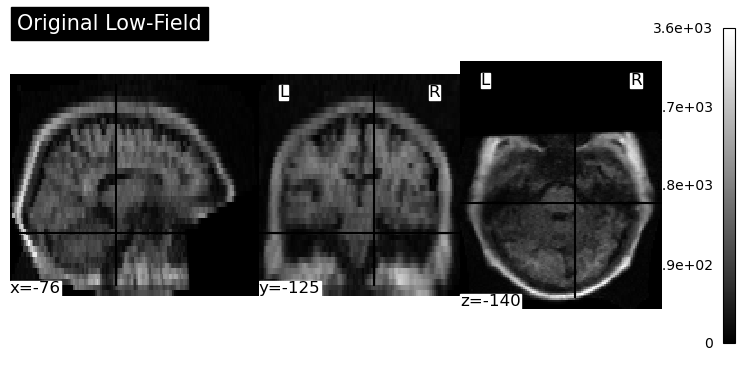

In [15]:
plot_image_trio(sample_path_pair)

### Synthetic Data


In [16]:
# plot_image_trio(sample_synthetic_path_pair)

## Datasets


In [17]:
class MRIPatchDataset(Dataset):
    def __init__(
        self,
        low_paths,
        high_paths,
        patches_per_vol=16,
        patch_size=96,
        transforms=None,
        # target_shape=(179, 221, 200),
    ):

        self.low_paths = low_paths
        self.high_paths = high_paths
        self.patches_per_vol = patches_per_vol
        self.patch_size = patch_size
        self.transforms = transforms
        self.data = []

        self.target_shape = (1, 1, 1)  # Will overwrite with new target shape

        print(
            "Loading entire dataset into RAM... (This takes ~1 min but speeds up training)"
        )

        for l_path, h_path in zip(low_paths, high_paths):
            # 2. Load High-Field ONCE

            fdata = nib.load(h_path).get_fdata()

            self.target_shape = fdata.shape
            # print(f"target_shape: {target_shape}")

            high_vol = torch.from_numpy(fdata).float().unsqueeze(0)

            # 1. Load and Upsample Low-Field ONCE
            # prepare_input should return tensor (C, D, H, W) or (C, H, W, D)
            low_vol, _ = prepare_input(l_path, target_shape=self.target_shape)

            # 3. Normalize ONCE
            low_vol = normalize_mri(low_vol)
            high_vol = normalize_mri(high_vol)

            # Store in list
            self.data.append({"low": low_vol, "high": high_vol})

    def __len__(self):
        return len(self.data) * self.patches_per_vol

    def __getitem__(self, idx):
        # Map the continuous index to a specific volume
        vol_idx = idx // self.patches_per_vol

        # Retrieve pre-loaded volumes from RAM
        low_vol = self.data[vol_idx]["low"]
        high_vol = self.data[vol_idx]["high"]

        # Get volume dimensions (C, D, H, W)
        # Note: Assuming dims are (1, 179, 221, 200) based on your description
        _, d, h, w = low_vol.shape

        # Ensure patch fits inside volume
        # We subtract patch_size so we don't index out of bounds
        # Safer patch starting points
        d_start = np.random.randint(0, max(1, d - self.patch_size))
        h_start = np.random.randint(0, max(1, h - self.patch_size))
        w_start = np.random.randint(0, max(1, w - self.patch_size))

        # Extract Patch
        low_patch = low_vol[
            :,
            d_start : d_start + self.patch_size,
            h_start : h_start + self.patch_size,
            w_start : w_start + self.patch_size,
        ]

        high_patch = high_vol[
            :,
            d_start : d_start + self.patch_size,
            h_start : h_start + self.patch_size,
            w_start : w_start + self.patch_size,
        ]

        # Apply MONAI Augmentations (Rotation, Flip, etc.)
        if self.transforms:
            # MONAI usually expects a dict input for MapTransforms
            data_dict = self.transforms({"low": low_patch, "high": high_patch})
            return data_dict["low"], data_dict["high"]

        return low_patch, high_patch

In [ ]:
## Uncomment for Project Data
low_field_paths = [os.path.join(LF_TRAIN, p) for p in os.listdir(LF_TRAIN)]
high_field_paths = [os.path.join(HF_TRAIN, p) for p in os.listdir(HF_TRAIN)]

# test_low_field_paths = [os.path.join(LF_TEST, p) for p in os.listdir(LF_TEST)]

# print(len(low_field_paths))

cap_size = min(4, len(low_field_paths))

train_size = min(3, cap_size)
val_size = cap_size - train_size


from monai.transforms import (
    Compose,
    RandFlipd,
    RandAffined,
    RandGaussianNoised,
    EnsureTyped,
)

# train_transforms = Compose(
#     [
#         # 1. Randomly flip along any axis (Spatial dims 0, 1, 2)
#         RandFlipd(keys=["low", "high"], prob=0.5, spatial_axis=[0, 1, 2]),
#         # 2. Slight rotations or scaling (optional, but helps generalization)
#         RandAffined(
#             keys=["low", "high"],
#             prob=0.2,
#             rotate_range=(0.1, 0.1, 0.1),
#             scale_range=(0.1, 0.1, 0.1),
#             mode=("trilinear", "trilinear"),
#         ),
#         # 3. Add noise ONLY to the input (low-field) to make model robust
#         RandGaussianNoised(keys=["low"], prob=0.2, mean=0.0, std=0.01),
#         EnsureTyped(keys=["low", "high"]),
#     ]
# )


train_dataset = MRIPatchDataset(
    low_field_paths[:train_size],
    high_field_paths[:train_size],
    # transforms=train_transforms,
)


val_dataset = MRIPatchDataset(
    low_field_paths[train_size : train_size + val_size],
    high_field_paths[train_size : train_size + val_size],
)

# test_dataset = MRITestPatchDataset(test_low_field_paths)

# SEED = 42
# torch.manual_seed(SEED)
# g = torch.Generator().manual_seed(SEED)  # Create a reproducible generator

# # 4. Perform the random split
# train_dataset, val_dataset = random_split(
#     full_dataset, [train_size, val_size], generator=g
# )


# print(train_dataset.low_paths)
# print(train_dataset.high_paths)

# train_dataset.__getitem__(0)
# train_dataset.__getitem__(0)[0].shape

Loading entire dataset into RAM... (This takes ~1 min but speeds up training)
Loading entire dataset into RAM... (This takes ~1 min but speeds up training)


In [19]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    # num_workers=1,
    pin_memory=True,
)

data_loaders = {"train": train_loader, "val": val_loader}

# test_loader = DataLoader(
#     dataset=test_dataset,
#     batch_size=1,
#     shuffle=False,
#     # num_workers=1,
#     pin_memory=True,
# )

# dataloader = DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     pin_memory=True,
# )

# print(f"Length of full dataset: {len(full_dataset)}")
print(f"Length of training dataset: {len(train_dataset)} patches")
print(f"Length of validation dataset: {len(val_dataset)} patches")
# print(f"Length of test dataset: {len(test_dataset)}")

Length of training dataset: 256 patches
Length of validation dataset: 32 patches


## Diffusion Model


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PriorNorm3D(nn.Module):
    """3D Feature-wise Linear Modulation"""

    def __init__(self, channels, latent_dim=64):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)  # GroupNorm natively supports 3D tensors!
        self.proj = nn.Linear(latent_dim, channels * 2)

        # Keep our zero-initialization to prevent NaNs
        nn.init.zeros_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)

    def forward(self, x, z):
        # Broadcast style correctly across the 3D spatial dimensions (Depth, Height, Width)
        style = self.proj(z).view(-1, x.shape[1] * 2, 1, 1, 1)
        gamma, beta = style.chunk(2, dim=1)
        return (1 + gamma) * self.norm(x) + beta


class PriorGuidedBlock3D(nn.Module):
    def __init__(self, channels, latent_dim):
        super().__init__()
        self.prior_norm1 = PriorNorm3D(channels, latent_dim)
        self.conv1 = nn.Conv3d(channels, channels, 3, padding=1)  # Upgraded to Conv3d
        self.prior_norm2 = PriorNorm3D(channels, latent_dim)
        self.conv2 = nn.Conv3d(channels, channels, 3, padding=1)  # Upgraded to Conv3d
        self.act = nn.SiLU()

    def forward(self, x, z):
        resid = x
        x = self.prior_norm1(x, z)
        x = self.act(self.conv1(x))
        x = self.prior_norm2(x, z)
        x = self.conv2(x)
        return x + resid


class Encoder3D(nn.Module):
    def __init__(self, in_channels=1, latent_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            # All convolutions and pooling are now 3D
            nn.Conv3d(in_channels, 32, 3, stride=2, padding=1),
            nn.GroupNorm(8, 32),
            nn.SiLU(),
            nn.Conv3d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv3d(64, 128, 3, stride=2, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(128, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


class DenoisingMLP(nn.Module):
    """Stays the same as before, since it operates purely on the 1D Latent space"""

    def __init__(self, latent_dim=64):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, 32), nn.SiLU(), nn.Linear(32, latent_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim * 3, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, z_t, cond, t):
        t_emb = self.time_embed(t.float().view(-1, 1))
        x = torch.cat([z_t, cond, t_emb], dim=1)
        return self.net(x)


class DiffMSR(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.latent_dim = 64
        self.T = 4

        self.PE = Encoder3D(1, self.latent_dim)
        self.CE = Encoder3D(1, self.latent_dim)
        self.diffusion = DenoisingMLP(self.latent_dim)

        # Upgraded Head and Tail to Conv3d
        self.head = nn.Conv3d(1, 64, 3, padding=1)
        self.body = nn.ModuleList(
            [PriorGuidedBlock3D(64, self.latent_dim) for _ in range(6)]
        )
        self.tail = nn.Conv3d(64, 1, 3, padding=1)

    def forward(self, low, high=None, stage="stage1"):
        # No more folding/reshaping! We process the 3D volume directly.
        if stage == "stage1":
            print("debug 2.1")
            z_gt = self.PE(high)
            print("debug 2.2")
            feat = self.head(low)
            print("debug 2.3")
            for block in self.body:
                feat = block(feat, z_gt)
                print("debug 2.4")
            pred = self.tail(feat) + low
            print("debug 2.5")
            return pred, z_gt, torch.tensor(0.0, device=self.device)

        elif stage == "stage2":
            with torch.no_grad():
                z_gt = self.PE(high)
            cond = self.CE(low)
            t = torch.randint(1, self.T + 1, (z_gt.size(0),), device=self.device)
            noise = torch.randn_like(z_gt)
            alpha = 1 - (t.float() / self.T).view(-1, 1)
            z_noisy = z_gt * alpha + noise * (1 - alpha)
            noise_pred = self.diffusion(z_noisy, cond, t)
            diff_loss = F.mse_loss(noise_pred, noise)
            return None, z_gt, diff_loss

        elif stage == "inference":
            cond = self.CE(low)
            z = torch.randn(cond.size(0), self.latent_dim, device=self.device)
            for i in reversed(range(1, self.T + 1)):
                t = torch.tensor([i] * cond.size(0), device=self.device)
                noise_pred = self.diffusion(z, cond, t)
                alpha = 1 - (i / self.T)
                if alpha > 0:
                    z = (z - noise_pred * (1 - alpha)) / alpha

            feat = self.head(low)
            for block in self.body:
                feat = block(feat, z)
            pred = self.tail(feat) + low
            return pred

### Metrics and Config


In [21]:
from monai.inferers.utils import sliding_window_inference
from monai.metrics.regression import SSIMMetric, PSNRMetric
from monai.losses.ssim_loss import SSIMLoss

# Initialize metrics
l1_criterion = torch.nn.L1Loss()
ssim_calc = SSIMMetric(spatial_dims=3)
psnr_calc = PSNRMetric(max_val=1.0)

ssim_criterion = SSIMLoss(spatial_dims=3)


# Metrics & Loss
class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.ssim = SSIMLoss(spatial_dims=3, data_range=1.0)

    def forward(self, pred, target):
        return 0.5 * self.l1(pred, target) + 0.5 * self.ssim(pred, target)


ssim_metric = SSIMMetric(spatial_dims=3, data_range=1.0)
psnr_metric = PSNRMetric(max_val=1.0)

## Training and Validation Setup


### Training Definitions


In [22]:
def train_diffmsr(model, loaders, criterion, opt_s1, opt_s2, num_epochs):
    scaler = torch.GradScaler("cuda") if CONFIG["DEVICE"] == "cuda" else None
    best_score = 0.0
    history = {"train_loss": [], "val_ssim": [], "val_psnr": []}

    switch_epoch = num_epochs // 2

    def inference_wrapper(x):
        return model(x, stage="inference")

    for epoch in range(num_epochs):
        # --- Configure Stage ---
        current_stage = "stage1" if epoch < switch_epoch else "stage2"
        optimizer = opt_s1 if epoch < switch_epoch else opt_s2

        model.PE.requires_grad_(current_stage == "stage1")
        model.CE.requires_grad_(current_stage == "stage2")
        model.diffusion.requires_grad_(current_stage == "stage2")
        for p in model.body.parameters():
            p.requires_grad = current_stage == "stage1"

        print(f"\nEpoch {epoch+1}/{num_epochs} | Mode: {current_stage.upper()}")

        # --- Train Loop ---
        model.train()
        running_loss = 0.0
        pbar = tqdm(loaders["train"], desc="Train")

        for low, high in pbar:

            # break

            low, high = low.to(CONFIG["DEVICE"]), high.to(CONFIG["DEVICE"])
            optimizer.zero_grad()

            with torch.autocast("cuda", enabled=(scaler is not None)):
                print("debug 1")
                pred_3d, _, diff_loss = model(low, high, stage=current_stage)
                print("debug 3")
                loss = (
                    criterion(pred_3d, high) if current_stage == "stage1" else diff_loss
                )
                
                print("debug 4")
                
                print("debug 5")

            if scaler:
                scaler.scale(loss).backward()
                print("debug 6")

                # --- NEW: Unscale and clip gradients before stepping ---
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                scaler.step(optimizer)
                scaler.update()
                print("debug 7")
            else:
                print("debug 8")
                loss.backward()
                # --- NEW: Clip gradients ---
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                print("debug 9")

            running_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # --- Validation Loop ---
        model.eval()
        ssim_metric.reset()
        # msssim_metric.reset()
        psnr_metric.reset()

        running_msssim = []

        with torch.no_grad():

            val_pbar = tqdm(loaders["val"], desc="Validate")

            for v_low, v_high in val_pbar:
                v_low, v_high = v_low.to(CONFIG["DEVICE"]), v_high.to(CONFIG["DEVICE"])

                # print(v_high)

                # print("low")
                # print(v_low)

                # print()
                # print("high")
                # print(v_high)

                # Use Sliding Window with the inference wrapper
                v_pred = sliding_window_inference(
                    v_low, CONFIG["PATCH_SIZE"], 4, inference_wrapper, overlap=0.25
                )
                # print()
                # print("v_pred")
                # print(v_pred)

                # IMPORTANT: MS-SSIM requires strict [0, 1] range
                v_pred = torch.clamp(v_pred, 0.0, 1.0)
                # v_pred = normalize_mri(v_pred)

                # print()
                # print("v_pred normalized")
                # print(v_pred)

                temp_pred = v_pred.cpu().numpy().squeeze()
                temp_high = v_high.cpu().numpy().squeeze()

                # print(temp_pred.shape)
                # print(temp_high.shape)

                for i in range(temp_pred.shape[0]):
                    slice_msssim = compute_ms_ssim(temp_pred[i], temp_high[i])

                    running_msssim.append(slice_msssim)

                # break
                # running_msssim += compute_ms_ssim(v_pred, v_high)
                # print(running_msssim)

                ssim_metric(y_pred=v_pred, y=v_high)
                psnr_metric(y_pred=v_pred, y=v_high)

                val_pbar.set_postfix(
                    {"mean running_msssim": f"{np.mean(running_msssim):.4f}"}
                )

        avg_msssim = np.mean(running_msssim)

        avg_ssim = ssim_metric.aggregate().item()
        avg_psnr = psnr_metric.aggregate().item()
        # combined_score = (0.5 * avg_ssim) + (0.5 * min(1.0, avg_psnr / 50.0))

        print(
            f"Val SSIM: {avg_ssim:.4f} | Val PSNR: {avg_psnr:.4f} | *** avg_msssim: {avg_msssim:.4f} ***"
        )

        history["train_loss"].append(running_loss / len(loaders["train"]))
        history["val_ssim"].append(avg_ssim)
        history["val_psnr"].append(avg_psnr)

        if avg_msssim > best_score:
            best_score = avg_msssim
            os.makedirs(CONFIG["PATHS"]["CHECKPOINT"], exist_ok=True)
            torch.save(
                model.state_dict(),
                os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "best_diffmsr.pt"),
            )
            print(">>> New Best Model Saved! <<<")

    return history

## Train Model


### Initialize Model


In [23]:
model = DiffMSR(device=CONFIG["DEVICE"]).to(CONFIG["DEVICE"])
criterion = nn.L1Loss()
# criterion = HybridLoss()

# Optimizer 1: Reconstruction
opt_s1 = torch.optim.AdamW(
    list(model.PE.parameters())
    + list(model.head.parameters())
    + list(model.body.parameters())
    + list(model.tail.parameters()),
    lr=CONFIG["LR"],
    weight_decay=CONFIG["WEIGHT_DECAY"],
)

# Optimizer 2: Diffusion
opt_s2 = torch.optim.AdamW(
    list(model.CE.parameters()) + list(model.diffusion.parameters()),
    lr=CONFIG["LR"],
    weight_decay=CONFIG["WEIGHT_DECAY"],
)

from wakepy import keep

with keep.running():
    history = train_diffmsr(
        model, data_loaders, criterion, opt_s1, opt_s2, CONFIG["NUM_EPOCHS"]
    )


Epoch 1/2 | Mode: STAGE1


Train:   0%|          | 0/256 [00:00<?, ?it/s]

debug 1
debug 2.1
debug 2.2
debug 2.3
debug 2.4
debug 2.4
debug 2.4
debug 2.4
debug 2.4
debug 2.4
debug 2.5
debug 3
debug 4
debug 5
debug 8


Train:   0%|          | 1/256 [01:59<8:29:07, 119.79s/it, loss=0.2540]

debug 9
debug 1
debug 2.1
debug 2.2
debug 2.3
debug 2.4
debug 2.4


Train:   0%|          | 1/256 [02:16<9:39:17, 136.30s/it, loss=0.2540]


KeyboardInterrupt: 

In [ ]:
import gc

# 2. Delete model and optimizers from GPU
if "model" in locals():
    del model
if "opt_s1" in locals():
    del opt_s1
if "opt_s2" in locals():
    del opt_s2

# 3. Force Python to collect garbage
gc.collect()

# 4. Clear the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(
        f"GPU Memory Freed: {torch.cuda.memory_reserved() / 1e9:.2f} GB remaining in cache"
    )

print("RAM and GPU memory cleared. You're ready for the next task!")

### Test Model


In [ ]:
# 1. Load Best Model
best_model = DiffMSR(device=CONFIG["DEVICE"]).to(CONFIG["DEVICE"])
ckpt_path = os.path.join(CONFIG["PATHS"]["CHECKPOINT"], "best_diffmsr.pt")
best_model.load_state_dict(torch.load(ckpt_path, map_location=CONFIG["DEVICE"]))
best_model.eval()


# 2. Wrapper for MONAI
def test_inference_wrapper(x):
    return best_model(x, stage="inference")


test_samples = ["sample_019", "sample_020", "sample_021", "sample_022", "sample_023"]
predictions = {}

with torch.no_grad():
    for sample_id in tqdm(test_samples, desc="Generating Submission"):
        low_path = (
            f"test/low_field/{sample_id}_lowfield.nii"  # Adjust extension if just .nii
        )

        # Upsample to Target Shape (179, 221, 200)
        full_vol, _ = prepare_input(low_path, target_shape=(179, 221, 200))
        test_input = (
            normalize_mri(full_vol).to(CONFIG["DEVICE"]).unsqueeze(0)
        )  # [1, 1, 179, 221, 200]

        # Sliding Window handles 3D patching automatically
        output = sliding_window_inference(
            test_input,
            CONFIG["PATCH_SIZE"],  # e.g., (96, 96, 96)
            sw_batch_size=4,
            predictor=test_inference_wrapper,
            overlap=0.5,
            mode="gaussian",  # Blends patch edges seamlessly
        )

        # Squeeze down to (179, 221, 200) and clip out-of-bounds values
        pred_volume = output.squeeze().cpu().numpy()
        pred_volume = np.clip(pred_volume, 0.0, 1.0)

        predictions[sample_id] = pred_volume

# 3. Save to CSV using the provided utility
submission_df = create_submission_df(predictions)
submission_df.to_csv("submission.csv", index=False)
print("✅ Submission successfully saved to submission.csv")


# 2. Delete model from GPU
if "best_model" in locals():
    del best_model

# 3. Force Python to collect garbage
# gc.collect()

# 4. Clear the CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(
        f"GPU Memory Freed: {torch.cuda.memory_reserved() / 1e9:.2f} GB remaining in cache"
    )

print("RAM and GPU memory cleared. You're ready for the next task!")

In [ ]:
import matplotlib.pyplot as plt

# 1. Get the first test sample results
sample_id = "sample_020"
pred_volume = predictions[sample_id]  # Shape (179, 221, 200)

# 2. Get the original upsampled input for comparison
low_path = f"test/low_field/{sample_id}_lowfield.nii"
input_tensor, _ = prepare_input(low_path)
input_tensor = normalize_mri(input_tensor)

input_volume = input_tensor.squeeze().cpu().numpy()  # Shape (179, 221, 200)

# 3. Select a middle axial slice (Index 100)
slice_idx = 100

plt.figure(figsize=(12, 6))

# Subplot 1: Input (Bicubic/Trilinear Upsampled)
plt.subplot(1, 2, 1)
plt.imshow(input_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"Upsampled Low-Field (Input)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

# Subplot 2: Model Prediction (Enhanced)
plt.subplot(1, 2, 2)
plt.imshow(pred_volume[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title(f"Model Enhancement (Prediction)\n{sample_id} - Slice {slice_idx}")
plt.axis("off")

plt.tight_layout()
plt.show()